# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
19c39fe2af2b547e48708ca005c6ae74        160         22           7   
c96d629dc0c39f0c616d1949938a6ba6       1016         22           0   
156c88bff4e9c4668b0f53df3d870f1b        582         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
19c39fe2af2b547e48708ca005c6ae74               0         0          57   
c96d629dc0c39f0c616d1949938a6ba6               1         0         119   
156c88bff4e9c4668b0f53df3d870f1b               2         2          12   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
19c39fe2af2b547e48708ca005c6ae74         0          0           0          1   
c96d629dc0c39f0c616d1949938a6ba6         0          3           3          5   
156c88bff4e9c4668b0f53df3d870f1b         3          1           2          9   

                                  ...   d5_stuns  d5_creeps_stacked  \
match_id_hash                     ...                                 
b9c57c450ce74a2af79c9ce96fac144d  ...   0.000000                  0   
6db558535151ea18ca70a6892197db41  ...   0.000000                  0   
19c39fe2af2b547e48708ca005c6ae74  ...   0.000000                  0   
c96d629dc0c39f0c616d1949938a6ba6  ...   8.264696                  0   
156c88bff4e9c4668b0f53df3d870f1b  ...  15.762911                  3   

                                  d5_camps_stacked  d5_rune_pickups  \
match_id_hash                                                         
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
19c39fe2af2b547e48708ca005c6ae74                 0                0   
c96d629dc0c39f0c616d1949938a6ba6                 0                3   
156c88bff4e9c4668b0f53df3d870f1b                 1                0   

                                  d5_firstblood_claimed  \
match_id_hash                                             
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
19c39fe2af2b547e48708ca005c6ae74                      0   
c96d629dc0c39f0c616d1949938a6ba6                      0   
156c88bff4e9c4668b0f53df3d870f1b                      1   

                                  d5_teamfight_participation  \
match_id_hash                                                  
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
19c39fe2af2b547e48708ca005c6ae74                        0.00   
c96d629dc0c39f0c616d1949938a6ba6                        0.25   
156c88bff4e9c4668b0f53df3d870f1b                        0.50   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
19c39fe2af2b547e48708ca005c6ae74                 0                  0   
c96d629dc0c39f0c616d1949938a6ba6                 0                  0   
156c88bff4e9c4668b0f53df3d870f1b                 0                  0   

                                  d5_obs_placed  d5_sen_placed  
match_id_hash              

Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

game_time  radiant_win  duration  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
6db558535151ea18ca70a6892197db41         21         True      1503   
19c39fe2af2b547e48708ca005c6ae74        160        False      2063   
c96d629dc0c39f0c616d1949938a6ba6       1016         True      2147   
156c88bff4e9c4668b0f53df3d870f1b        582        False      1927   

                                  time_remaining next_roshan_team  
match_id_hash                                                      
b9c57c450ce74a2af79c9ce96fac144d             496              NaN  
6db558535151ea18ca70a6892197db41            1482          Radiant  
19c39fe2af2b547e48708ca005c6ae74            1903              NaN  
c96d629dc0c39f0c616d1949938a6ba6            1131          Radiant  
156c88bff4e9c4668b0f53df3d870f1b            1345             Dire

## <left>Наша первая модель

In [6]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [8]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 48.9 s, sys: 143 ms, total: 49.1 s
Wall time: 6.58 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [9]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [10]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [11]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [12]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                            index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [16]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(''.join(['../data/', submission_filename]))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-25_21-06-11.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [17]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [18]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 13 s, sys: 1.02 s, total: 14 s
Wall time: 52.6 s


In [19]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [20]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строк
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [23]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [24]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

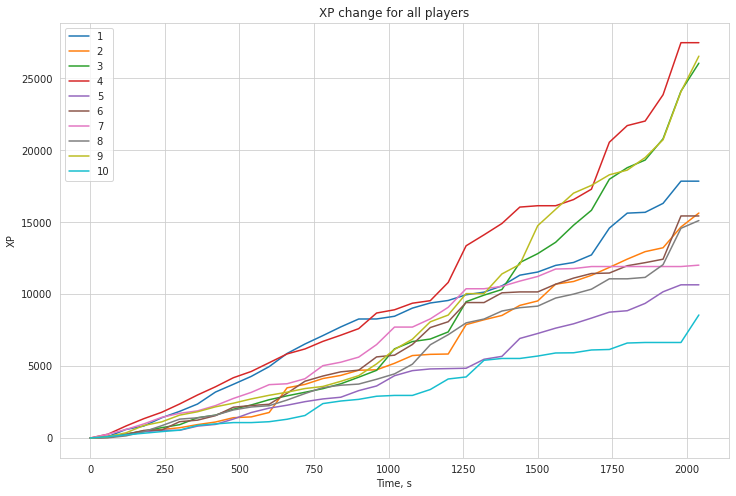

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [26]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [27]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [28]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [35]:
df_train_features_extended.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
19c39fe2af2b547e48708ca005c6ae74        160         22           7   
c96d629dc0c39f0c616d1949938a6ba6       1016         22           0   
156c88bff4e9c4668b0f53df3d870f1b        582         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
19c39fe2af2b547e48708ca005c6ae74               0         0          57   
c96d629dc0c39f0c616d1949938a6ba6               1         0         119   
156c88bff4e9c4668b0f53df3d870f1b               2         2          12   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
19c39fe2af2b547e48708ca005c6ae74         0          0           0          1   
c96d629dc0c39f0c616d1949938a6ba6         0          3           3          5   
156c88bff4e9c4668b0f53df3d870f1b         3          1           2          9   

                                  ...  d5_rune_pickups  d5_firstblood_claimed  \
match_id_hash                     ...                                           
b9c57c450ce74a2af79c9ce96fac144d  ...                0                      0   
6db558535151ea18ca70a6892197db41  ...                0                      0   
19c39fe2af2b547e48708ca005c6ae74  ...                0                      0   
c96d629dc0c39f0c616d1949938a6ba6  ...                3                      0   
156c88bff4e9c4668b0f53df3d870f1b  ...                0                      1   

                                  d5_teamfight_participation  \
match_id_hash                                                  
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
19c39fe2af2b547e48708ca005c6ae74                        0.00   
c96d629dc0c39f0c616d1949938a6ba6                        0.25   
156c88bff4e9c4668b0f53df3d870f1b                        0.50   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
19c39fe2af2b547e48708ca005c6ae74                 0                  0   
c96d629dc0c39f0c616d1949938a6ba6                 0                  0   
156c88bff4e9c4668b0f53df3d870f1b                 0                  0   

                                  d5_obs_placed  d5_sen_placed  \
match_id_hash                                                    
b9c57c450ce74a2af79c9ce96fac144d              0              0   
6db558535151ea18ca70a6892197db41              0              0   
19c39fe2af2b547e48708ca005c6ae74              0              0   
c96d629dc0c39f0c616d1949938a6ba6              3              0   
156c88bff4e9c4668b0f53df3d870f1b              3              0   

                                  radiant_tower_kills  dire_tower_kills  \
match_id_hash                                                             
b9c57c450ce74a2af79c9ce96fac144d                  2.0               0.0   
6db558535151ea18ca70a6892197db41                  0.0               0.0   
19c39fe2af2b547e48708ca005c6ae74                  0.0               0.0   
c96d629dc0c39f0c616d1949938a6ba6                  0.0               0.0   
156c88bff4e9c4668b0f5

In [30]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 147 ms, sys: 407 ms, total: 554 ms
Wall time: 1min 16s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Прочитаем побольше всего

In [112]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills, dire_tower_kills = 0, 0
        
        # и другие данные
        first_blood = 0
        aegis_radiant, aegis_dire = 0, 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0
        
        len_teamfights = len(match['teamfights'])

        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_dire += 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
        

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill
        df_features.loc[match_id_hash, "len_teamfights"] = len_teamfights
        
        df_features.loc[match_id_hash, "aegis_radiant"] = aegis_radiant
        df_features.loc[match_id_hash, "aegis_dire"] = aegis_dire
        df_features.loc[match_id_hash, "aegis_diff"] = aegis_radiant - aegis_dire
        
        df_features.loc[match_id_hash, "aegis_stolen_radiant"] = aegis_stolen_radiant
        df_features.loc[match_id_hash, "aegis_stolen_dire"] = aegis_stolen_dire
        df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant - aegis_stolen_dire
        
        df_features.loc[match_id_hash, "aegis_denied_radiant"] = aegis_denied_radiant
        df_features.loc[match_id_hash, "aegis_denied_dire"] = aegis_denied_dire
        df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant - aegis_denied_dire
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [113]:
# Скопируем таблицу с признаками
train = df_train_features.copy()

# Добавим новые
add_new_features(train, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [115]:
train.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
19c39fe2af2b547e48708ca005c6ae74        160         22           7   
c96d629dc0c39f0c616d1949938a6ba6       1016         22           0   
156c88bff4e9c4668b0f53df3d870f1b        582         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
19c39fe2af2b547e48708ca005c6ae74               0         0          57   
c96d629dc0c39f0c616d1949938a6ba6               1         0         119   
156c88bff4e9c4668b0f53df3d870f1b               2         2          12   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
19c39fe2af2b547e48708ca005c6ae74         0          0           0          1   
c96d629dc0c39f0c616d1949938a6ba6         0          3           3          5   
156c88bff4e9c4668b0f53df3d870f1b         3          1           2          9   

                                  ...  aegis_diff  aegis_stolen_radiant  \
match_id_hash                     ...                                     
b9c57c450ce74a2af79c9ce96fac144d  ...         0.0                   0.0   
6db558535151ea18ca70a6892197db41  ...         0.0                   0.0   
19c39fe2af2b547e48708ca005c6ae74  ...         0.0                   0.0   
c96d629dc0c39f0c616d1949938a6ba6  ...         0.0                   0.0   
156c88bff4e9c4668b0f53df3d870f1b  ...         0.0                   0.0   

                                  aegis_stolen_dire  aegis_stolen_diff  \
match_id_hash                                                            
b9c57c450ce74a2af79c9ce96fac144d                0.0                0.0   
6db558535151ea18ca70a6892197db41                0.0                0.0   
19c39fe2af2b547e48708ca005c6ae74                0.0                0.0   
c96d629dc0c39f0c616d1949938a6ba6                0.0                0.0   
156c88bff4e9c4668b0f53df3d870f1b                0.0                0.0   

                                  aegis_denied_radiant  aegis_denied_dire  \
match_id_hash                                                               
b9c57c450ce74a2af79c9ce96fac144d                   0.0                0.0   
6db558535151ea18ca70a6892197db41                   0.0                0.0   
19c39fe2af2b547e48708ca005c6ae74                   0.0                0.0   
c96d629dc0c39f0c616d1949938a6ba6                   0.0                0.0   
156c88bff4e9c4668b0f53df3d870f1b                   0.0                0.0   

                                  aegis_denied_diff  radiant_roshan_kills  \
match_id_hash                                                               
b9c57c450ce74a2af79c9ce96fac144d                0.0                   0.0   
6db558535151ea18ca70a6892197db41                0.0                   0.0   
19c39fe2af2b547e48708ca005c6ae74                0.0                   0.0   
c96d629dc0c39f0c616d1949938a6ba6                0.0                   0.0   
156c88bff4e9c4668b0f53df3d870f1b                0.0                   0.0   

                                  dire_roshan_kills  diff_roshan_kills  
match_id_hash                                                           
b9c57c450ce74a2af79c9ce96fac144d                0.0                0.0  
6db558535151ea18ca70a6892197db41                0.0                0.0  
19c39fe2af2b547e48708ca005c6ae74              

# Some EDA

In [135]:
train.iloc[:,:20]

game_time  game_mode  lobby_type  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
19c39fe2af2b547e48708ca005c6ae74        160         22           7   
c96d629dc0c39f0c616d1949938a6ba6       1016         22           0   
156c88bff4e9c4668b0f53df3d870f1b        582         22           7   
...                                     ...        ...         ...   
b794aa55646841a03c7783226e6f6bc8       2666         22           0   
308faee28efee2e66b39f9f2ba6ea9cf       2525         22           0   
6066cc7417b43c749d551e123d00f0c8       1002          4           0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5        377         22           7   
e2ca68ac1a6847f4a37f6c9c8ee8695b        643         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
19c39fe2af2b547e48708ca005c6ae74               0         0          57   
c96d629dc0c39f0c616d1949938a6ba6               1         0         119   
156c88bff4e9c4668b0f53df3d870f1b               2         2          12   
...                                          ...       ...         ...   
b794aa55646841a03c7783226e6f6bc8              23         8          99   
308faee28efee2e66b39f9f2ba6ea9cf              15         5          22   
6066cc7417b43c749d551e123d00f0c8               4         0           1   
bc7a87ed5f9c2bca55f9f7a93da0b0c5               1         0          14   
e2ca68ac1a6847f4a37f6c9c8ee8695b               1        23          63   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
19c39fe2af2b547e48708ca005c6ae74         0          0           0          1   
c96d629dc0c39f0c616d1949938a6ba6         0          3           3          5   
156c88bff4e9c4668b0f53df3d870f1b         3          1           2          9   
...                                    ...        ...         ...        ...   
b794aa55646841a03c7783226e6f6bc8         9         11           9          3   
308faee28efee2e66b39f9f2ba6ea9cf         3          9          14          3   
6066cc7417b43c749d551e123d00f0c8         1          2           1          0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5         0          2           1          1   
e2ca68ac1a6847f4a37f6c9c8ee8695b         1          4           0          2   

                                  r1_gold  r1_lh  r1_xp  r1_health  \
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d     5257     52   3937       1160   
6db558535151ea18ca70a6892197db41      176      0      0        680   
19c39fe2af2b547e48708ca005c6ae74      403      0    359        740   
c96d629dc0c39f0c616d1949938a6ba6     3085      1   2828        495   
156c88bff4e9c4668b0f53df3d870f1b     3516     40   3964        495   
...                                   ...    ...    ...        ...   
b794aa55646841a03c7783226e6f6bc8    19850    251  25448          0   
308faee28efee2e66b39f9f2ba6ea9cf    13914    151  19592       1478   
6066cc7417b43c749d551e123d00f0c8     4613     59   4478        880   
bc7a87ed5f9c2bca55f9f7a93da0b0c5      809      2   1102          0   
e2ca68ac1a6847f4a37f6c9c8ee8695b     1747      4   2677        369   

                                  r1_max_health  r1_max_mana  r1_level  r1_x  \
match_id_hash                                                                  
b9c57c450ce74a2af79c9ce96fac144d           1160 

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Columns: 263 entries, game_time to diff_roshan_kills
dtypes: float64(48), int64(215)
memory usage: 64.9+ MB


In [119]:
train.describe()

game_time     game_mode    lobby_type  objectives_len      chat_len  \
count  31698.000000  31698.000000  31698.000000    31698.000000  31698.000000   
mean    1146.519496     19.583538      4.771563        6.535239      7.358982   
std      766.936655      6.306635      3.260899        6.486933     13.295763   
min        0.000000      2.000000      0.000000        0.000000      0.000000   
25%      521.000000     22.000000      0.000000        1.000000      0.000000   
50%     1044.000000     22.000000      7.000000        4.000000      3.000000   
75%     1659.000000     22.000000      7.000000       10.000000      9.000000   
max     4933.000000     23.000000      7.000000       43.000000    291.000000   

         r1_hero_id      r1_kills     r1_deaths    r1_assists     r1_denies  \
count  31698.000000  31698.000000  31698.000000  31698.000000  31698.000000   
mean      51.081614      3.151713      3.273361      4.661998      6.255600   
std       34.573173      3.727116      3.281208      5.207887      8.144267   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       20.000000      0.000000      1.000000      1.000000      1.000000   
50%       44.000000      2.000000      2.000000      3.000000      3.000000   
75%       81.000000      5.000000      5.000000      7.000000      9.000000   
max      120.000000     32.000000     27.000000     40.000000     83.000000   

       ...    aegis_diff  aegis_stolen_radiant  aegis_stolen_dire  \
count  ...  31698.000000          31698.000000       31698.000000   
mean   ...      0.012146              0.003470           0.002965   
std    ...      0.571602              0.058807           0.054376   
min    ...     -5.000000              0.000000           0.000000   
25%    ...      0.000000              0.000000           0.000000   
50%    ...      0.000000              0.000000           0.000000   
75%    ...      0.000000              0.000000           0.000000   
max    ...      4.000000              1.000000           1.000000   

       aegis_stolen_diff  aegis_denied_radiant  aegis_denied_dire  \
count       31698.000000          31698.000000       31698.000000   
mean            0.000505              0.000505           0.000347   
std             0.080223              0.022462           0.018626   
min            -1.000000              0.000000           0.000000   
25%             0.000000              0.000000           0.000000   
50%             0.000000              0.000000           0.000000   
75%             0.000000              0.000000           0.000000   
max             1.000000              1.000000           1.000000   

       aegis_denied_diff  radiant_roshan_kills  dire_roshan_kills  \
count       31698.000000          31698.000000       31698.000000   
mean            0.000158              0.146161           0.134362   
std             0.029185              0.421817           0.409403   
min            -1.000000              0.000000           0.000000   
25%             0.000000              0.000000           0.000000   
50%             0.000000              0.000000           0.000000   
75%             0.000000              0.000000           0.000000   
max             1.000000              5.000000           5.000000   

       diff_roshan_kills  
count       31698.000000  
mean            0.011799  
std             0.579040  
min            -5.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             5.000000  

[8 rows x 263 columns]

In [132]:
train.isnull().sum().sum()

0

In [142]:
train.iloc[:,5:20]

r1_hero_id  r1_denies  r1_gold  r1_lh  \
match_id_hash                                                             
b9c57c450ce74a2af79c9ce96fac144d          15          7     5257     52   
6db558535151ea18ca70a6892197db41         101          0      176      0   
19c39fe2af2b547e48708ca005c6ae74          57          1      403      0   
c96d629dc0c39f0c616d1949938a6ba6         119          5     3085      1   
156c88bff4e9c4668b0f53df3d870f1b          12          9     3516     40   
...                                      ...        ...      ...    ...   
b794aa55646841a03c7783226e6f6bc8          99          3    19850    251   
308faee28efee2e66b39f9f2ba6ea9cf          22          3    13914    151   
6066cc7417b43c749d551e123d00f0c8           1          0     4613     59   
bc7a87ed5f9c2bca55f9f7a93da0b0c5          14          1      809      2   
e2ca68ac1a6847f4a37f6c9c8ee8695b          63          2     1747      4   

                                  r1_xp  r1_health  r1_max_health  \
match_id_hash                                                       
b9c57c450ce74a2af79c9ce96fac144d   3937       1160           1160   
6db558535151ea18ca70a6892197db41      0        680            680   
19c39fe2af2b547e48708ca005c6ae74    359        740            740   
c96d629dc0c39f0c616d1949938a6ba6   2828        495            740   
156c88bff4e9c4668b0f53df3d870f1b   3964        495            960   
...                                 ...        ...            ...   
b794aa55646841a03c7783226e6f6bc8  25448          0           2805   
308faee28efee2e66b39f9f2ba6ea9cf  19592       1478           2035   
6066cc7417b43c749d551e123d00f0c8   4478        880            880   
bc7a87ed5f9c2bca55f9f7a93da0b0c5   1102          0            900   
e2ca68ac1a6847f4a37f6c9c8ee8695b   2677        369            780   

                                  r1_max_mana  r1_level  r1_x  r1_y  \
match_id_hash                                                         
b9c57c450ce74a2af79c9ce96fac144d    566.93805         8    76    78   
6db558535151ea18ca70a6892197db41    506.93800         1   118   118   
19c39fe2af2b547e48708ca005c6ae74    290.93777         2    92   148   
c96d629dc0c39f0c616d1949938a6ba6    816.93830         6   112   112   
156c88bff4e9c4668b0f53df3d870f1b    530.93800         8   120   118   
...                                       ...       ...   ...   ...   
b794aa55646841a03c7783226e6f6bc8   2179.93970        24   152   148   
308faee28efee2e66b39f9f2ba6ea9cf   2197.93970        21   132   136   
6066cc7417b43c749d551e123d00f0c8    410.93790         9   152    92   
bc7a87ed5f9c2bca55f9f7a93da0b0c5    290.93777         4    84   156   
e2ca68ac1a6847f4a37f6c9c8ee8695b    422.93790         6    80   138   

                                   r1_stuns  r1_creeps_stacked  \
match_id_hash                                                    
b9c57c450ce74a2af79c9ce96fac144d   0.000000                  0   
6db558535151ea18ca70a6892197db41   0.000000                  0   
19c39fe2af2b547e48708ca005c6ae74   0.000000                  0   
c96d629dc0c39f0c616d1949938a6ba6  21.451569                  0   
156c88bff4e9c4668b0f53df3d870f1b   0.000000                  0   
...                                     ...                ...   
b794aa55646841a03c7783226e6f6bc8   0.000000                  0   
308faee28efee2e66b39f9f2ba6ea9cf   4.672524                  1   
6066cc7417b43c749d551e123d00f0c8   0.000019                  0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5   1.266357                  0   
e2ca68ac1a6847f4a37f6c9c8ee8695b   0.000000                  0   

                                  r1_camps_stacked  r1_rune_pickups  
match_id_hash                                                        
b9c57c450ce74a2af79c9ce96fac144d                 0                0  
6db558535151ea18ca70a6892197db41                 0                0  
19c39fe2af2b547e48708ca005c6ae74                 0                1  
c96d629dc0c39f0c616d1949938

In [141]:
# make KDA for each player
for i in range(1, 6):
    train[f'd{i}_KDA'] = (train[f'd{i}_kills'] + train[f'd{i}_assists']) / train[f'd{i}_deaths']
    train[f'r{i}_KDA'] = (train[f'r{i}_kills'] + train[f'r{i}_assists']) / train[f'r{i}_deaths']
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)

In [143]:
# health for  each player
for i in range(1, 6):
    train[f'r{i}_pc_health'] = train[f'r{i}_health'] / train[f'r{i}_max_health']
    train[f'd{i}_pc_health'] = train[f'd{i}_health'] / train[f'd{i}_max_health']
    
    train = train.drop([f'r{i}_health', f'r{i}_max_health', f'd{i}_health', f'd{i}_max_health'], axis=1)

In [146]:
train.iloc[:,5:20]

r1_hero_id  r1_denies  r1_gold  r1_lh  \
match_id_hash                                                             
b9c57c450ce74a2af79c9ce96fac144d          15          7     5257     52   
6db558535151ea18ca70a6892197db41         101          0      176      0   
19c39fe2af2b547e48708ca005c6ae74          57          1      403      0   
c96d629dc0c39f0c616d1949938a6ba6         119          5     3085      1   
156c88bff4e9c4668b0f53df3d870f1b          12          9     3516     40   
...                                      ...        ...      ...    ...   
b794aa55646841a03c7783226e6f6bc8          99          3    19850    251   
308faee28efee2e66b39f9f2ba6ea9cf          22          3    13914    151   
6066cc7417b43c749d551e123d00f0c8           1          0     4613     59   
bc7a87ed5f9c2bca55f9f7a93da0b0c5          14          1      809      2   
e2ca68ac1a6847f4a37f6c9c8ee8695b          63          2     1747      4   

                                  r1_xp  r1_max_mana  r1_level  r1_x  r1_y  \
match_id_hash                                                                
b9c57c450ce74a2af79c9ce96fac144d   3937    566.93805         8    76    78   
6db558535151ea18ca70a6892197db41      0    506.93800         1   118   118   
19c39fe2af2b547e48708ca005c6ae74    359    290.93777         2    92   148   
c96d629dc0c39f0c616d1949938a6ba6   2828    816.93830         6   112   112   
156c88bff4e9c4668b0f53df3d870f1b   3964    530.93800         8   120   118   
...                                 ...          ...       ...   ...   ...   
b794aa55646841a03c7783226e6f6bc8  25448   2179.93970        24   152   148   
308faee28efee2e66b39f9f2ba6ea9cf  19592   2197.93970        21   132   136   
6066cc7417b43c749d551e123d00f0c8   4478    410.93790         9   152    92   
bc7a87ed5f9c2bca55f9f7a93da0b0c5   1102    290.93777         4    84   156   
e2ca68ac1a6847f4a37f6c9c8ee8695b   2677    422.93790         6    80   138   

                                   r1_stuns  r1_creeps_stacked  \
match_id_hash                                                    
b9c57c450ce74a2af79c9ce96fac144d   0.000000                  0   
6db558535151ea18ca70a6892197db41   0.000000                  0   
19c39fe2af2b547e48708ca005c6ae74   0.000000                  0   
c96d629dc0c39f0c616d1949938a6ba6  21.451569                  0   
156c88bff4e9c4668b0f53df3d870f1b   0.000000                  0   
...                                     ...                ...   
b794aa55646841a03c7783226e6f6bc8   0.000000                  0   
308faee28efee2e66b39f9f2ba6ea9cf   4.672524                  1   
6066cc7417b43c749d551e123d00f0c8   0.000019                  0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5   1.266357                  0   
e2ca68ac1a6847f4a37f6c9c8ee8695b   0.000000                  0   

                                  r1_camps_stacked  r1_rune_pickups  \
match_id_hash                                                         
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
19c39fe2af2b547e48708ca005c6ae74                 0                1   
c96d629dc0c39f0c616d1949938a6ba6                 0               18   
156c88bff4e9c4668b0f53df3d870f1b                 0                2   
...                                            ...              ...   
b794aa55646841a03c7783226e6f6bc8                 0               11   
308faee28efee2e66b39f9f2ba6ea9cf                 1                5   
6066cc7417b43c749d551e123d00f0c8                 0                2   
bc7a87ed5f9c2bca55f9f7a93da0b0c5                 0                0   
e2ca68ac1a6847f4a37f6c9c8ee8695b                 0                4   

                                  r1_firstblood_claimed  \
match_id_hash                                             
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
19c39fe2af2b547e48708ca0

In [156]:
for i in range(1, 6):
    print(train[[f'r{i}_level', f'r{i}_xp']].corr())

          r1_level     r1_xp
r1_level  1.000000  0.973307
r1_xp     0.973307  1.000000
          r2_level     r2_xp
r2_level  1.000000  0.973125
r2_xp     0.973125  1.000000
          r3_level     r3_xp
r3_level  1.000000  0.973374
r3_xp     0.973374  1.000000
          r4_level     r4_xp
r4_level  1.000000  0.973228
r4_xp     0.973228  1.000000
          r5_level     r5_xp
r5_level  1.000000  0.973169
r5_xp     0.973169  1.000000


In [157]:
for i in range(1, 6):
    print(train[[f'd{i}_level', f'd{i}_xp']].corr())

          d1_level     d1_xp
d1_level  1.000000  0.973569
d1_xp     0.973569  1.000000
          d2_level     d2_xp
d2_level  1.000000  0.973276
d2_xp     0.973276  1.000000
          d3_level     d3_xp
d3_level  1.000000  0.973352
d3_xp     0.973352  1.000000
          d4_level     d4_xp
d4_level  1.000000  0.973324
d4_xp     0.973324  1.000000
          d5_level     d5_xp
d5_level  1.000000  0.973229
d5_xp     0.973229  1.000000


количество опыта с уровнем сильно коррелируют, оставим только уровень.

In [158]:
for i in range(1, 6):
    train = train.drop([f'd{i}_xp', f'r{i}_xp'], axis=1)

In [161]:
train.iloc[:,5:20]

r1_hero_id  r1_denies  r1_gold  r1_lh  \
match_id_hash                                                             
b9c57c450ce74a2af79c9ce96fac144d          15          7     5257     52   
6db558535151ea18ca70a6892197db41         101          0      176      0   
19c39fe2af2b547e48708ca005c6ae74          57          1      403      0   
c96d629dc0c39f0c616d1949938a6ba6         119          5     3085      1   
156c88bff4e9c4668b0f53df3d870f1b          12          9     3516     40   
...                                      ...        ...      ...    ...   
b794aa55646841a03c7783226e6f6bc8          99          3    19850    251   
308faee28efee2e66b39f9f2ba6ea9cf          22          3    13914    151   
6066cc7417b43c749d551e123d00f0c8           1          0     4613     59   
bc7a87ed5f9c2bca55f9f7a93da0b0c5          14          1      809      2   
e2ca68ac1a6847f4a37f6c9c8ee8695b          63          2     1747      4   

                                  r1_max_mana  r1_level  r1_x  r1_y  \
match_id_hash                                                         
b9c57c450ce74a2af79c9ce96fac144d    566.93805         8    76    78   
6db558535151ea18ca70a6892197db41    506.93800         1   118   118   
19c39fe2af2b547e48708ca005c6ae74    290.93777         2    92   148   
c96d629dc0c39f0c616d1949938a6ba6    816.93830         6   112   112   
156c88bff4e9c4668b0f53df3d870f1b    530.93800         8   120   118   
...                                       ...       ...   ...   ...   
b794aa55646841a03c7783226e6f6bc8   2179.93970        24   152   148   
308faee28efee2e66b39f9f2ba6ea9cf   2197.93970        21   132   136   
6066cc7417b43c749d551e123d00f0c8    410.93790         9   152    92   
bc7a87ed5f9c2bca55f9f7a93da0b0c5    290.93777         4    84   156   
e2ca68ac1a6847f4a37f6c9c8ee8695b    422.93790         6    80   138   

                                   r1_stuns  r1_creeps_stacked  \
match_id_hash                                                    
b9c57c450ce74a2af79c9ce96fac144d   0.000000                  0   
6db558535151ea18ca70a6892197db41   0.000000                  0   
19c39fe2af2b547e48708ca005c6ae74   0.000000                  0   
c96d629dc0c39f0c616d1949938a6ba6  21.451569                  0   
156c88bff4e9c4668b0f53df3d870f1b   0.000000                  0   
...                                     ...                ...   
b794aa55646841a03c7783226e6f6bc8   0.000000                  0   
308faee28efee2e66b39f9f2ba6ea9cf   4.672524                  1   
6066cc7417b43c749d551e123d00f0c8   0.000019                  0   
bc7a87ed5f9c2bca55f9f7a93da0b0c5   1.266357                  0   
e2ca68ac1a6847f4a37f6c9c8ee8695b   0.000000                  0   

                                  r1_camps_stacked  r1_rune_pickups  \
match_id_hash                                                         
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
19c39fe2af2b547e48708ca005c6ae74                 0                1   
c96d629dc0c39f0c616d1949938a6ba6                 0               18   
156c88bff4e9c4668b0f53df3d870f1b                 0                2   
...                                            ...              ...   
b794aa55646841a03c7783226e6f6bc8                 0               11   
308faee28efee2e66b39f9f2ba6ea9cf                 1                5   
6066cc7417b43c749d551e123d00f0c8                 0                2   
bc7a87ed5f9c2bca55f9f7a93da0b0c5                 0                0   
e2ca68ac1a6847f4a37f6c9c8ee8695b                 0                4   

                                  r1_firstblood_claimed  \
match_id_hash                                             
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
19c39fe2af2b547e48708ca005c6ae74                      0   
c96d629dc0c39f0c616d1949938a6ba6                      0 

In [166]:
for i in range(1, 6):
    print(train[[f'd{i}_lh', f'd{i}_gold']].corr())

            d1_lh   d1_gold
d1_lh    1.000000  0.867097
d1_gold  0.867097  1.000000
           d2_lh  d2_gold
d2_lh    1.00000  0.86494
d2_gold  0.86494  1.00000
            d3_lh   d3_gold
d3_lh    1.000000  0.868328
d3_gold  0.868328  1.000000
            d4_lh   d4_gold
d4_lh    1.000000  0.867114
d4_gold  0.867114  1.000000
            d5_lh   d5_gold
d5_lh    1.000000  0.862931
d5_gold  0.862931  1.000000
